# treatment of foot data lines with buffer with cph grid 

exploration of the cph grid with the trajectories, see how the trajectories are spreaded in the grid and how many hexagons are visited. creation of grid_to_trip.csv tbale where its saves the hex id and wich traj visited it. need to ask if i should keep duplicates in this tabkle for example a trajectory crosses more time the same hex shoul i keep more lines in this dataset or it's just one? 

also plot of trajectoies and its touched hex and a heatmap of the most visited hex 

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import os

In [2]:
data_path = "/home/s232713/data/"

grid = gpd.read_file(os.path.join(data_path, "grid_data/cph_hexgrid.geojson"))

foot_df = pd.read_pickle(os.path.join(data_path, "trajectories/foot_data_trajectory_buffer.pkl"))
foot_gdf = gpd.GeoDataFrame(foot_df, geometry=foot_df["buffer"], crs=grid.crs) 
# buffer already in the same crs of the grid 
#foot_gdf = foot_gdf.to_crs(grid.crs) # ensure that grid and foot_gdf have the same CRS

# which hexagons are touched by buffer
mask = grid.intersects(foot_gdf.union_all(method='unary')) # .unary_union combines all buffers in one big geometry
seen_hexes = grid[mask] 

#print(foot_gdf.union_all(method='unary'))
#print(seen_hexes)

n_total = len(grid)
n_seen = len(seen_hexes)
perc_seen = n_seen / n_total * 100

print(f"Total hexagons: {n_total}")
print(f"Seen hexagons: {n_seen}")
print(f"Percentage seen: {perc_seen:.2f}%")



Total hexagons: 308878
Seen hexagons: 12920
Percentage seen: 4.18%


In [3]:
# seen_hexes.to_file("cph_hexgrid_seen.geojson", driver="GeoJSON")

In [3]:
# --- Per-trajectory coverage ---
results = []
for traj_id, traj in foot_gdf.groupby("Interval ID"):
    mask = grid.intersects(traj.union_all(method='unary'))
    n_seen = mask.sum()
    perc_seen = n_seen / n_total * 100
    results.append({"Interval ID": traj_id, "seen_hexes": n_seen, "perc_seen": perc_seen})

results = pd.DataFrame(results)
print(results)

      Interval ID  seen_hexes  perc_seen
0          265109           6   0.001943
1          266118          22   0.007123
2          266360          10   0.003238
3          266417           3   0.000971
4          266600          17   0.005504
...           ...         ...        ...
2398       713666           8   0.002590
2399       713727           8   0.002590
2400       713729          23   0.007446
2401       714231           7   0.002266
2402       714232          17   0.005504

[2403 rows x 3 columns]


In [4]:
print(results['seen_hexes'].value_counts())
print('percentage of traj that see 0 hexagons:', (results['seen_hexes']==0).sum()/len(results)*100,'%')

seen_hexes
0      385
9      146
8      143
7      134
10     120
      ... 
90       1
127      1
80       1
82       1
105      1
Name: count, Length: 119, dtype: int64
percentage of traj that see 0 hexagons: 16.021639617145237 %


the 0 seen hexagons are path that are outside the grid's boundaries 


Plotting Interval ID = 549525


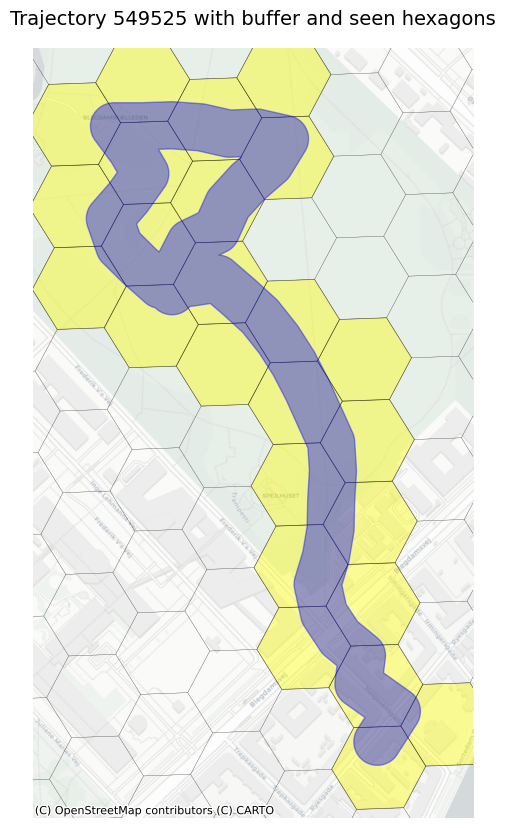

In [6]:
# --- Plot a sample trajectory with its buffer and hex grid ---
sample_id = 549525 
print(f"\nPlotting Interval ID = {sample_id}")

traj = foot_gdf.loc[foot_gdf["Interval ID"] == sample_id]

# reproject to web mercator for basemap
grid_web = grid.to_crs(epsg=3857)
traj_web = traj.to_crs(epsg=3857)

# which hexes this trajectory touches
mask = grid.intersects(traj.union_all(method="unary"))
seen_hexes = grid[mask].to_crs(epsg=3857)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
grid_web.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.2, alpha=0.5, zorder=1)
seen_hexes.plot(ax=ax, facecolor="yellow", edgecolor="black", linewidth=0.5, alpha=0.4, zorder=2)
traj_web.plot(ax=ax, color="blue", alpha=0.4, edgecolor="blue", zorder=3)
minx, miny, maxx, maxy = traj_web.total_bounds
ax.set_xlim(minx-100, maxx+100)
ax.set_ylim(miny-100, maxy+100)


ctx.add_basemap(ax, crs=grid_web.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"Trajectory {sample_id} with buffer and seen hexagons", fontsize=14)

ax.set_axis_off()
plt.show()

outpath = "/home/s232713/figures/buffer_grid_example.pdf"
fig.savefig(
    outpath,
    format="pdf",
    bbox_inches="tight"
)

plt.close(fig)

In [7]:
# For each hex, count how many trajectories intersect it
grid["traj_count"] = 0

for traj_id, traj in foot_gdf.groupby("Interval ID"):
    mask = grid.intersects(traj.union_all(method="unary"))
    grid.loc[mask, "traj_count"] += 1


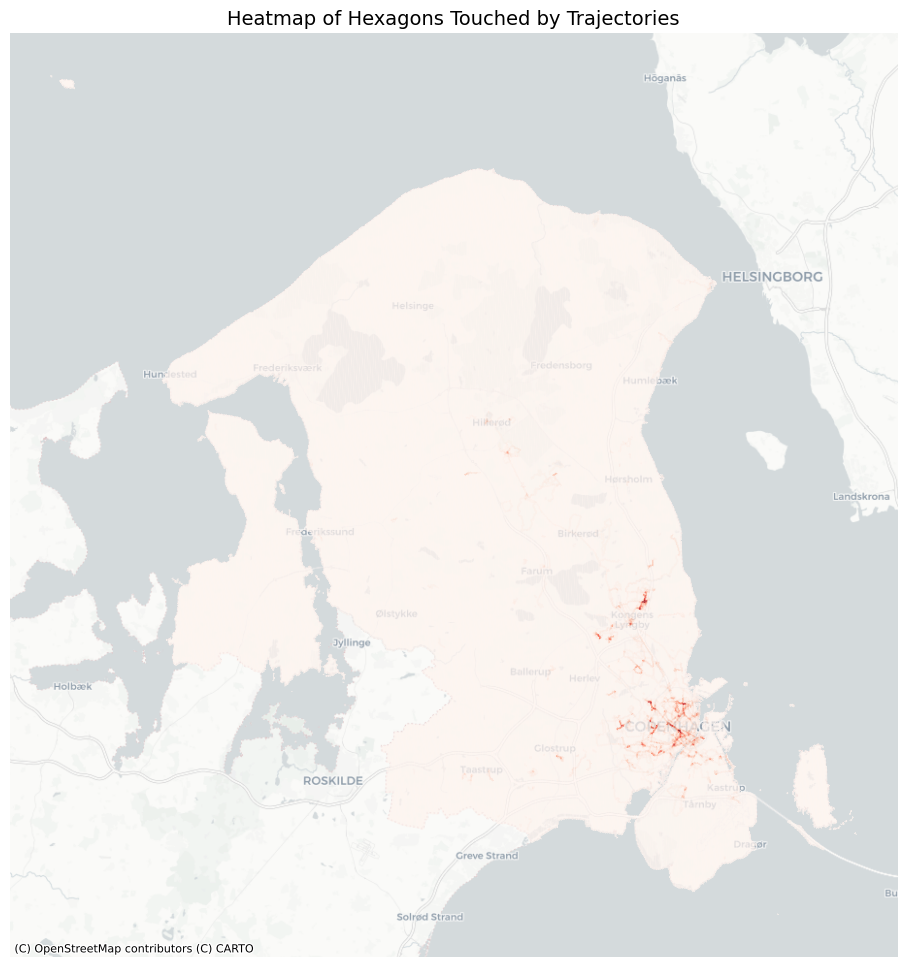

In [ ]:
grid_web = grid.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
grid_web.plot(
    ax=ax,
    column="traj_count",
    cmap="Reds",         # red = more visits
    linewidth=0,
    legend=False,
    legend_kwds={"label": "Number of trajectories"}

)

ctx.add_basemap(ax, crs=grid_web.crs, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("Heatmap of Hexagons Touched by Trajectories", fontsize=14)

ax.set_axis_off()
plt.show()

outpath = "/home/s232713/figures/heatmap_grid.pdf"
fig.savefig(
    outpath,
    format="pdf",
    bbox_inches="tight"
)

plt.close(fig)


In [8]:
# saving the foot data only the one inside the boundaries of the grid
grid_union = grid.union_all(method='unary')

foot_in = foot_gdf[foot_gdf.intersects(grid_union)]

print(f"Original trajectories: {len(foot_gdf)}")
print(f"Inside boundary: {len(foot_in)}")

# Save as pickle
foot_in.to_pickle(os.path.join(data_path, "trajectories/FINAL_foot_data.pkl"))

Original trajectories: 2403
Inside boundary: 2018


In [9]:
foot_in.shape

(2018, 513)

now creation of a dataset that says for every interval_id wich grid_id passes

In [10]:
# grid = GeoDataFrame with GRID_ID column
# foot_gdf = GeoDataFrame with Interval ID + buffer geometry

join = gpd.sjoin(grid, foot_gdf, how="inner", predicate="intersects")

# Keep only needed columns
grid_trip = join[["GRID_ID", "Interval ID"]]

# Drop if a traj touches more time the same hex, not sure need to ask that if it makes sense
# grid_trip = grid_trip.drop_duplicates()

print(grid_trip.head())

# Save table
grid_trip.to_csv(data_path + "grid_data/grid_to_trip.csv", index=False)


      GRID_ID  Interval ID
8989     8989       692434
8990     8990       692434
8991     8991       692434
8992     8992       692434
8993     8993       692434


In [11]:
# count how many interval id there are in the grid_trip
n_intervals = grid_trip["Interval ID"].nunique()
print(f"Number of unique Interval IDs: {n_intervals}")
n_hex = grid_trip['GRID_ID'].nunique()
print(f"Number of hexagons touched by a trajectory: {n_hex}")


Number of unique Interval IDs: 2018
Number of hexagons touched by a trajectory: 12920


In [12]:
foot_df = pd.read_pickle("/home/s232713/data/trajectories/FINAL_foot_data.pkl")
print(foot_df.shape)


(2018, 513)


In [13]:
foot_df.head()

,Activity_concat,Mean_HR_cond,Mean_HR_cond_zscored,RMSSD_activity_concat,RMSSD_50_points_timeframe,pNN50_activity_concat,LF_activity_concat,HF_activity_concat,LF_HF_ratio_activity_concat,RMSSD_activity_concat_50_points,...,Motorcyclist_perc_Mapillary,Other Rider_perc_Mapillary,Car_perc_Mapillary,Truck_perc_Mapillary,Bus_perc_Mapillary,On Rails_perc_Mapillary,Motorcycle_perc_Mapillary,Bicycle_perc_Mapillary,geometry,buffer
0,Foot,118.310243,2.501799,30.165853,135.866640,0.090909,1.491876,15.911834,0.093759,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((335872.971 6188539.416, 335876.117 6...","POLYGON ((335872.971 6188539.416, 335876.117 6..."
1,Foot,61.236816,-0.694272,79.448426,63.831307,0.395833,977.797097,1072.080871,0.912055,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((335878.035 6188579.886, 335866.803 6...","POLYGON ((335878.035 6188579.886, 335866.803 6..."
2,Foot,72.921468,-0.039940,179.432564,151.101521,0.875000,315.163092,2397.064478,0.131479,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((343455.472 6195439.666, 343454.605 6...","POLYGON ((343455.472 6195439.666, 343454.605 6..."
3,Foot,103.608392,1.678506,NaN,27.387029,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((334203.756 6189152.499, 334207.624 6...","POLYGON ((334203.756 6189152.499, 334207.624 6..."
4,Foot,101.686300,1.570870,82.890378,62.220357,0.428571,173.886405,1093.223293,0.159058,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((334105.126 6188808.472, 334102.796 6...","POLYGON ((334105.126 6188808.472, 334102.796 6..."


In [3]:
import pandas as pd
traj_path = "/home/s232713/data/trajectories/FINAL_foot_data.pkl"
df_traj = pd.read_pickle(traj_path)

print(df_traj.shape)
print(df_traj['Interval ID'].nunique())
print(df_traj['INDIVID'].nunique())

(2018, 513)
2018
110
